# Breast Cancer資料集特徵工程
特徵工程分為三種:
1. 特徵縮放(Feature Scaling): 標準化、常態化
2. 特徵選取(Feature Selection): 從多個特徵中選出影響較大的幾個特徵，例如SBS、Random Forece
3. 特徵萃取(Feature Extraction or Feature Transformation):將多個特徵融合為數個，例如PCA、LCA、Kernel PCA(用於非線性切割)

特徵工程對於專案的成功與否是非常重要，特徵縮放可以避免某個特徵數據過大影響結果，而特徵選取與特徵萃取則是達到降維效果，其實特徵=維度，維度過高除了增加電腦運算的成本外，還會造成**過度擬合(overfit)與維度災難(cause dimensionality)**。
- 過度擬合: 訓練時分數極高，但測試時分數極低，這是因為資料集中有些特徵並不會影響y，但電腦做訓練時，卻一定會參考這些特徵進行運算。
- 維度災難: 我們在從母群體取樣分析時，當維度提高，會稀釋樣本在母體中的比重。

個人認為特徵選取與特徵萃取，最重要的是找出主要影響 y 的特徵。

**本篇使用scikit learn之乳癌資料集，分別採取1種特徵選取，與1種特徵萃取進行特徵工程**
1. Feature Selection：Random Forest
2. Feature Extraction：PCA(Principal Component Analysis)  
3. Feature Extraction：LDA(Linear Discriminant Analysis)

由與乳癌的結果為"有病"、"沒病"，兩種結果，所以進行Logistic Regression，比較兩者的準確度。

[乳癌資料來源](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html)

## 一、載入入資料
由於是從未見過資料集，在載入前應先檢查一下欄位、數據

In [44]:
# 載入資料並查看欄位
from sklearn import datasets
ds = datasets.load_breast_cancer()
print(ds.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

In [45]:
# 查看數據
import pandas as pd
X = pd.DataFrame(ds.data, columns=ds.feature_names)
X.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [46]:
# 設定y
y = ds.target

In [47]:
# 檢查空值
X.isnull().sum()

mean radius                0
mean texture               0
mean perimeter             0
mean area                  0
mean smoothness            0
mean compactness           0
mean concavity             0
mean concave points        0
mean symmetry              0
mean fractal dimension     0
radius error               0
texture error              0
perimeter error            0
area error                 0
smoothness error           0
compactness error          0
concavity error            0
concave points error       0
symmetry error             0
fractal dimension error    0
worst radius               0
worst texture              0
worst perimeter            0
worst area                 0
worst smoothness           0
worst compactness          0
worst concavity            0
worst concave points       0
worst symmetry             0
worst fractal dimension    0
dtype: int64

In [48]:
# 切割資料為訓練組與測試組
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train.shape,  X_test.shape, y_train.shape, y_test.shape 

((455, 30), (114, 30), (455,), (114,))

共30個欄位(特徵)

## 二、Feature Selection_Random Forest 
[Feature Selection參考網址](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

Random Force，中文名稱為隨機森林，會依序刪除某一特徵來評估對效能之影響，影響最大的就是最重要之特徵。

### 2.1 找出2個最重要特徵

In [49]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

feat_labels = ds.feature_names

forest = RandomForestClassifier(n_estimators=500)  #參數說明請參考Feature Selection參考網址

#使用訓練資料進行RandomForest
forest.fit(X_train, y_train)
importances = forest.feature_importances_

# 透過argsort進行排列(預設為升冪，-為降冪)
indices = np.argsort(-importances)
#indices = np.argsort(importances)[::-1]  #-->也可以這樣寫(參考)

# 顯示特徵名稱與分數
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

 1) worst perimeter                0.130513
 2) worst area                     0.122406
 3) worst concave points           0.120299
 4) mean concave points            0.104780
 5) worst radius                   0.098913
 6) mean perimeter                 0.054101
 7) worst concavity                0.051072
 8) mean concavity                 0.050530
 9) mean radius                    0.041075
10) mean area                      0.034360
11) area error                     0.028642
12) worst texture                  0.022759
13) perimeter error                0.018146
14) mean texture                   0.016995
15) worst compactness              0.012475
16) worst smoothness               0.012428
17) worst symmetry                 0.011169
18) mean compactness               0.009832
19) radius error                   0.009538
20) mean smoothness                0.006799
21) worst fractal dimension        0.006009
22) concavity error                0.005546
23) texture error               

### 2.2 繪製直方圖

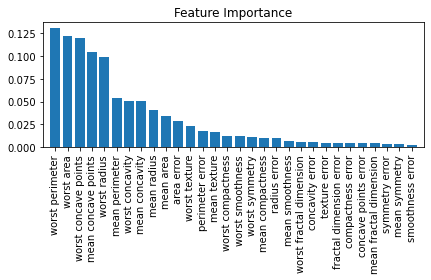

In [50]:
import matplotlib.pyplot as plt
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), 
        importances[indices],
        align='center')

plt.xticks(range(X_train.shape[1]), 
           feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
#plt.savefig('images/04_09.png', dpi=300)
plt.show()

### 2.3 保留最佳的2個特徵

In [51]:
# 重要特徵之欄位index:降冪排列後，取前2個
top_2 = np.argsort(-importances)[0:2]
#top_2 = np.argsort(importances)[::-1][0:2]
top_2

array([22, 23], dtype=int64)

In [52]:
# 修改X_train的資料欄位
X_train_forest = X_train.iloc[:,top_2]
X_train_forest

,worst perimeter,worst area
280,159.80,1724.0
434,102.30,777.5
20,96.09,630.5
441,132.80,1284.0
238,102.50,764.0
...,...,...
87,152.90,1623.0
167,130.70,1260.0
482,94.94,660.2
105,106.40,827.2


In [53]:
#修改X_test的資料欄位
X_test_forest = X_test.iloc[:,top_2]
X_test_forest

,worst perimeter,worst area
257,119.80,928.8
283,126.90,1031.0
336,87.38,576.0
320,71.53,390.4
364,93.76,663.5
...,...,...
469,88.14,528.1
428,74.35,421.1
406,115.90,947.9
460,152.10,1648.0


### 2.4 LogisticRegression訓練
由於乳癌資料之結果為有病，沒病之類別變數，所以採用LogisticRegression演算法

In [54]:
from sklearn.linear_model import LogisticRegression
logistic = LogisticRegression()
logistic.fit(X_train_forest, y_train)

LogisticRegression()

In [55]:
logistic.coef_

array([[-0.15930631, -0.00067089]])

### 2.5 準確度
由於乳癌資料之結果為有病，沒病之類別變數，所以採用accuracy_score

In [56]:
# 準確度
from sklearn.metrics import accuracy_score
# 計算測試資料之 y 預測值
y_pred_forest = logistic.predict(X_test_forest)

accuracy_score(y_test, y_pred_forest)

0.9122807017543859

## 三、 Feature Extraction：PCA
[PCA參考網址](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)  

PCA，全名為Principal Component Analysis，中文名為主成分分析。將數據轉換，投影到低維的特徵空間，是一種保留最多資訊為前提的數據壓縮方法。

**PCA可以用於非監督演算法**

本篇會萃取2個最重要特徵後，進行LogisticRegression，與準確度

### 3.1 PCA
萃取出2個重要特徵，設定n_components=2

In [57]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2) #components->萃取2個變數
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

### 3.2 LogisticRegression

In [58]:
# 訓練
from sklearn.linear_model import LogisticRegression
logisticPCA = LogisticRegression(multi_class='ovr', random_state=1, solver='lbfgs')
logisticPCA.fit(X_train_pca, y_train)

LogisticRegression(multi_class='ovr', random_state=1)

### 3.3 準確度

In [59]:
# 準確度
y_pred_pca = logisticPCA.predict(X_test_pca)
accuracy_score(y_test, y_pred_pca)

0.9473684210526315

### 3.4 繪製決策邊界

In [60]:
# 決策邊界函數，只適用於2個特徵
from matplotlib.colors import ListedColormap
def plot_decision_regions(X, y, classifier, resolution=0.2):
    # 定義顏色和點圖形
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # 尋找2個特徵之最小值與最大值
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    
    # 定義圖形之X軸、Y軸之最小與最大值，定義解析度
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    
    # 預測之結果為Z軸
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    
    # contourf:繪製等高線，填滿相同高度的部分
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap) 
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # 散佈圖
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.6, 
                    color=cmap(idx),
                    edgecolor='black',
                    marker=markers[idx], 
                    label=cl)

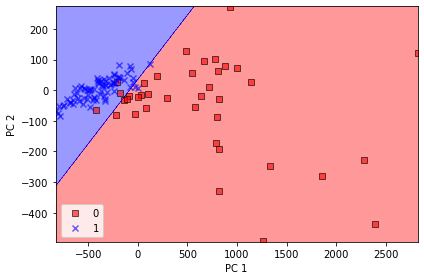

In [61]:
#決策邊界
plot_decision_regions(X_test_pca, y_test, classifier=logisticPCA)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('images/05_04.png', dpi=300)
plt.show()

### 3.5 補充80/20法則
又稱為帕累托法則(Pareto principle)，由義大利經濟學家帕累托提出"只有20%的變因操縱80%的局面"，因此可以使用Pareto chart找出造成80%之結果的特徵為何?

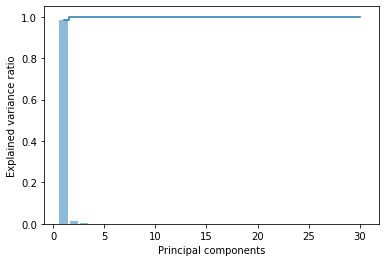

In [62]:
# 繪製Pareto chart
# PCA()若無設定參數，融合後特徵數不變
pca_pareto = PCA()
X_train_pca = pca_pareto.fit_transform(X_train)
pca_pareto.explained_variance_ratio_

# 繪製直方圖
plt.bar(range(1, X_train.shape[1]+1), 
        pca_pareto.explained_variance_ratio_, 
        alpha=0.5, 
        align='center')

# 繪製累加的Pareto chart
plt.step(range(1, X_train.shape[1]+1), 
         np.cumsum(pca_pareto.explained_variance_ratio_), 
         where='mid')

# X軸與Y軸標籤
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')

plt.show()

**透過pareto chart可知影響y的31個特徵中，只有1個特徵的影響達到90%以上**

In [63]:
# PCA 80/20法則應用
pca_80 = PCA(0.8)
X_train_pca_80 = pca_80.fit_transform(X_train)
pca_80.explained_variance_ratio_

array([0.98286784])

只有一個萃取後的特徵達到80%

## 四、LDA
LDA全名為Linear Discriminant Analysis，中文名為線性判別分析，本篇依舊使用scikit learn 來進行特徵萃取出2個特徵  
[scikit learn 參考資料](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html)

### 4.1 LDA

In [74]:
from sklearn.decomposition import LatentDirichletAllocation as LDA
lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train, y_train)
X_test_lda = lda.transform(X_test)

### 4.2 LogisticRegression

In [77]:
from sklearn.linear_model import LogisticRegression
logisticLDA = LogisticRegression()
logisticLDA.fit(X_train_lda, y_train)

LogisticRegression()

### 4.3 準確度

In [78]:
from sklearn.metrics import accuracy_score
y_pred_lda = logisticLDA.predict(X_test_lda)
accuracy_score(y_test, y_pred_lda)

0.8947368421052632

### 4.4 繪製決策邊界

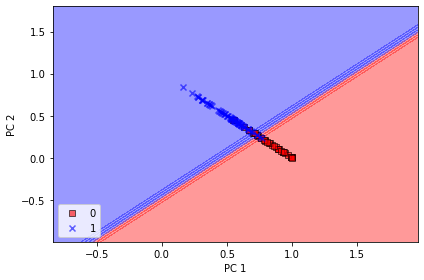

In [79]:
#決策邊界:plot_decision_regions函式在3.4中
plot_decision_regions(X_test_lda, y_test, classifier=logisticLDA)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

## 全部程式碼
由於訓練組與測試組會從新分配，所以結果會有所不同。

In [81]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.decomposition import LatentDirichletAllocation as LDA

X, y = datasets.load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# RandomForestClassifier
forest = RandomForestClassifier(n_estimators=500)
forest.fit(X_train, y_train)
importances = forest.feature_importances_
top_2 = np.argsort(-importances)[0:2]
X_train_forest = X_train[:,top_2]
LogisticRegression().fit(X_train_forest, y_train)
y_pred_forest = logistic.predict(X_test[:,top_2])
accuray_forest = accuracy_score(y_test, y_pred_forest)
print("特徵選取_隨機森林準確度=", accuray_forest)

# PCA
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
logisticPCA = LogisticRegression(multi_class='ovr', random_state=1, solver='lbfgs')
logisticPCA.fit(X_train_pca, y_train)
y_pred_pca = logisticPCA.predict(X_test_pca)
accuracy_pca = accuracy_score(y_test, y_pred_pca)
print("特徵萃取_PCA準確度=", accuracy_pca)

#LDA
lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train, y_train)
X_test_lda = lda.transform(X_test)
logisticLDA = LogisticRegression()
logisticLDA.fit(X_train_lda, y_train)
y_pred_lda = logisticLDA.predict(X_test_lda)
accuracy_lda = accuracy_score(y_test, y_pred_lda)
print("特徵萃取_LDA準確度=", accuracy_lda)

特徵選取_隨機森林準確度= 0.42105263157894735
特徵萃取_PCA準確度= 0.8947368421052632
特徵萃取_LDA準確度= 0.868421052631579
